In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math
from utils_custom import *

In [2]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [3]:
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

#### Load enriched link as per state

In [4]:
#Red = PB, Blue = GC
state_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/gene_colors.csv'
enriched_links_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_7_3_GC_PB.csv'
# store the state_LF in a df
state_LF = pd.read_csv(state_LF_file)
enriched_links = pd.read_csv(enriched_links_file)

In [5]:
def create_enriched_links_per_state(enriched_links, state_LF):
    # Create dictionaries to map genes to their states
    gene_to_state = dict(zip(state_LF['gene'], state_LF['color']))

    # Initialize lists to store links for each state
    state1_links = []  # For Red (PB)
    state2_links = []  # For Blue (GC)
    TFs = set()
    targets_in_lf = set()

    # Iterate over each row in the enriched_links DataFrame
    for _, row in enriched_links.iterrows():
        tf_str = row['TF']
        # Extract the TF name from the string representation of a tuple
        tf = tf_str.strip("(,)' ").replace("'", "")
        TFs.add(tf)
        
        # Handle the targets as a string representation of a list
        if isinstance(row['common'], str):
            # If it's a string representation of a list, convert it to a list
            targets_str = row['common'].strip("[]").replace("'", "")
            targets = [t.strip() for t in targets_str.split(",")]
        else:
            # If it's already a list
            targets = row['common']
    
        # Assign each TF-target pair to the appropriate state
        for target in targets:
            if target and target in gene_to_state:
                targets_in_lf.add(target)
                state = gene_to_state[target]
                link = (tf, target)
                if state == 'Red':
                    state1_links.append(link)
                elif state == 'Blue':
                    state2_links.append(link)
    TFs = list(TFs)
    targets_in_lf = list(targets_in_lf)

    return state1_links, state2_links, TFs, targets_in_lf

In [6]:
PB_links, GC_links, TFs, targets_in_lf = create_enriched_links_per_state(enriched_links, state_LF)

In [7]:
# filter the TFs that are not in the dynamic object
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, TFs)
# Remove items that are not in the dynamic object
filtered_TFs = [item for item in TFs if item not in missing_tfs]

#update the GC_links and PB_links
GC_links = [link for link in GC_links if link[0] in filtered_TFs]
PB_links = [link for link in PB_links if link[0] in filtered_TFs]


In [113]:
PB_links_plotting = [('BACH2','XBP1'),('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [45]:
TF_TF_GC_links = [('IRF4','PAX5'),('IRF4','AFF3'),('PAX5','XBP1'),('PAX5','PRDM1'),('NFKB1','PAX5')]

In [59]:
GC_links = [('ARID5B','PIKFYVE'),('IRF4','CDK6')]

#### Load the network and get force values (PB/GC)

In [10]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object,varname='w_in')) #varname='w_in' total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [11]:
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 100)

In [14]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [15]:
# get target indices 
lf_genes_indices = get_gene_indices(dictys_dynamic_object, targets_in_lf)

In [16]:
# Get the subnetworks for the enriched TFs
filtered_subnetworks = dnet[np.ix_(TF_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(13, 35, 100)

In [17]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in filtered_TFs for target in targets_in_lf]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)

#### Slice the enriched links from the entire subnetwork (PB/GC)

In [102]:
enriched_betas = lf_beta_dcurve.loc[PB_links_plotting]
print(enriched_betas.shape)

(16, 100)


#### Get the expression curves for all the TFs (PB/GC)

In [39]:
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")

In [103]:
# get the tf_lcpms for the lineage
tf_list = enriched_betas.index.get_level_values('TF').unique().tolist()
enriched_tfs_lcpm_dcurve = lcpm_dcurve.loc[tf_list]
print(len(enriched_tfs_lcpm_dcurve))

7


In [104]:
lf_forces_dcurve = calculate_force_curves(enriched_betas, enriched_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                               
RUNX2   PRDM1   0.125408  0.137284  0.149108  0.160804  0.172303  0.183548   
CREB3L2 RUNX2   0.138696  0.141140  0.143656  0.146252  0.148930  0.151692   
IRF4    CDK6    0.700723  0.709377  0.717334  0.724593  0.731162  0.737057   
CREB3L2 FNDC3A  0.589542  0.599762  0.609968  0.620116  0.630157  0.640043   
        MZB1    0.177492  0.194691  0.211864  0.229021  0.246161  0.263272   

                  time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                          ...             
RUNX2   PRDM1   0.194489  0.205082  0.215289  0.225075  ...  0.131397   
CREB3L2 RUNX2   0.154535  0.157455  0.160446  0.163503  ...  0.122971   
IRF4    CDK6    0.742302  0.746923  0.750955  0.754432  ... -0.284323   
CREB3L2 FNDC3A  0.649724  0.659152  0.668281  0.677069  ... -0.177182   
        MZB1    0.280338  0.297343  0.314268  0.331100  ... -0.311150   

                 time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                               
RUNX2   PRDM1   0.131541  0.131312  0.130735  0.129833  0.128625  0.127130   
CREB3L2 RUNX2   0.120397  0.117356  0.113877  0.109975  0.105657  0.100917   
IRF4    CDK6   -0.286186 -0.288054 -0.289916 -0.291761 -0.293578 -0.295356   
CREB3L2 FNDC3A -0.172659 -0.166646 -0.158956 -0.149302 -0.137203 -0.121790   
        MZB1   -0.310684 -0.310107 -0.309406 -0.308567 -0.307580 -0.306434   

                 time_97   time_98   time_99  
TF      Target                                
RUNX2   PRDM1   0.125361  0.123331  0.121049  
CREB3L2 RUNX2   0.095737  0.090077  0.083870  
IRF4    CDK6   -0.297086 -0.298755 -0.300356  
CREB3L2 FNDC3A -0.101198 -0.069613  0.050065  
        MZB1   -0.305119 -0.303629 -0.301956  

[5 rows x 100 columns]

(16, 100)

In [99]:
def plot_force_heatmap_with_clustering(
    force_df: pd.DataFrame,
    dtime: pd.Series,
    regulations=None,
    tf_to_targets_dict=None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    vmax: Optional[float] = None,
    figsize: Tuple[float, float] = (10, 8),
    plot_figure: bool = True,
    perform_clustering: bool = True,
    cluster_method: str = "ward",
    dtop: float = 0,
    dright: float = 0.3,
) -> Tuple[pd.DataFrame, list, pd.Series, Optional[matplotlib.figure.Figure]]:
    """
    Prepares force value data for clustering heatmap and optionally plots it.
    """
    # Process input parameters to generate regulation pairs
    reg_pairs = []
    reg_labels = []
    # Case 1: Dictionary of TF -> targets provided
    if tf_to_targets_dict is not None:
        for tf, targets in tf_to_targets_dict.items():
            for target in targets:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
    # Case 2: List of regulation pairs or list of targets for a single TF
    elif regulations is not None:
        # Check if first item is a string (target) or tuple/list (regulation pair)
        if regulations and isinstance(regulations[0], str):
            # It's a list of targets for a single TF
            # Extract TF name from the calling context (not ideal but works for the notebook)
            for key, value in locals().items():
                if (
                    isinstance(value, dict)
                    and "PRDM1" in value
                    and value["PRDM1"] == regulations
                ):
                    tf = "PRDM1"  # Found the TF
                    break
            else:
                # If we can't determine the TF, use the first item in regulations as TF
                # and the rest as targets (this is a fallback and might not be correct)
                tf = regulations[0]
                regulations = regulations[1:]

            for target in regulations:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
        else:
            # It's a list of regulation pairs
            reg_pairs = regulations
            reg_labels = [f"{tf}->{target}" for tf, target in regulations]
    # If no regulations provided, use non-zero regulations from force_df
    if not reg_pairs:
        non_zero_mask = (force_df != 0).any(axis=1)
        force_df_filtered = force_df[non_zero_mask]
        reg_pairs = list(force_df_filtered.index)
        reg_labels = [f"{tf}->{target}" for tf, target in reg_pairs]
    # Extract force values for the specified regulations
    force_values = []
    for pair in reg_pairs:
        tf, target = pair
        try:
            force_values.append(force_df.loc[(tf, target)].values)
        except KeyError:
            raise ValueError(f"Regulation {tf}->{target} not found in force DataFrame")
    # Convert to numpy array
    dnet = np.array(force_values)
    
    # Convert dnet to DataFrame with proper labels
    force_df_for_cluster = pd.DataFrame(
        dnet, 
        index=reg_labels,
        columns=[f"{x:.4f}" for x in dtime]
    )
    
    # Plotting logic
    fig = None
    if plot_figure:
        # Calculate max absolute value for symmetric color scaling
        vmax_val = float(force_df_for_cluster.abs().max().max()) if vmax is None else vmax
        
        if perform_clustering:
            # Use cluster_heatmap for visualization
            fig, cols, rows = cluster_heatmap(
                d=force_df_for_cluster,
                optimal_ordering=True,
                method=cluster_method,
                metric="euclidean",
                cmap=cmap,
                aspect=0.1,
                figscale=0.02,
                dtop=dtop,      # Set to > 0 to enable clustering on columns (pseudotime)
                dright=dright,  # Set to > 0 to enable clustering on rows (regulations)
                wcolorbar=0.03,
                wedge=0.03,
                ytick=True,
                vmin=-vmax_val,
                vmax=vmax_val,
                figsize=figsize
            )
            plt.title("Clustered Force Heatmap")
        else:
            # Simple heatmap without clustering
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(dnet, aspect='auto', interpolation='none', cmap=cmap,
                          vmin=-vmax_val, vmax=vmax_val)
            
            # Add colorbar
            plt.colorbar(im, label="Force")
            
            # Set pseudotime labels as x axis labels
            ax.set_xlabel("Pseudotime")
            num_ticks = 10
            tick_positions = np.linspace(0, dnet.shape[1] - 1, num_ticks, dtype=int)
            tick_labels = dtime.iloc[tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([f"{x:.4f}" for x in tick_labels], rotation=45, ha="right")
            
            # Set regulation pair labels
            ax.set_yticks(list(range(len(reg_labels))))
            ax.set_yticklabels(reg_labels)
            
            # Add grid lines
            ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
            
        plt.tight_layout()
    
    return force_df_for_cluster, reg_labels, dtime, fig

#### Plot the PB/GC links

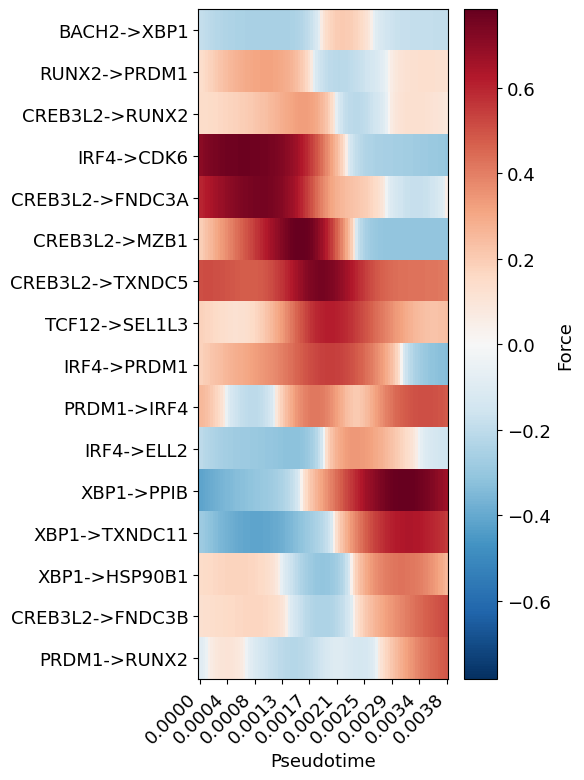

In [115]:
force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=PB_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (6, 8),
    plot_figure=True,
    perform_clustering=False
)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/enriched_links_PB.pdf', 
            bbox_inches='tight', 
            dpi=100,
            format='pdf')
plt.show()


## Selecting the links for plotting

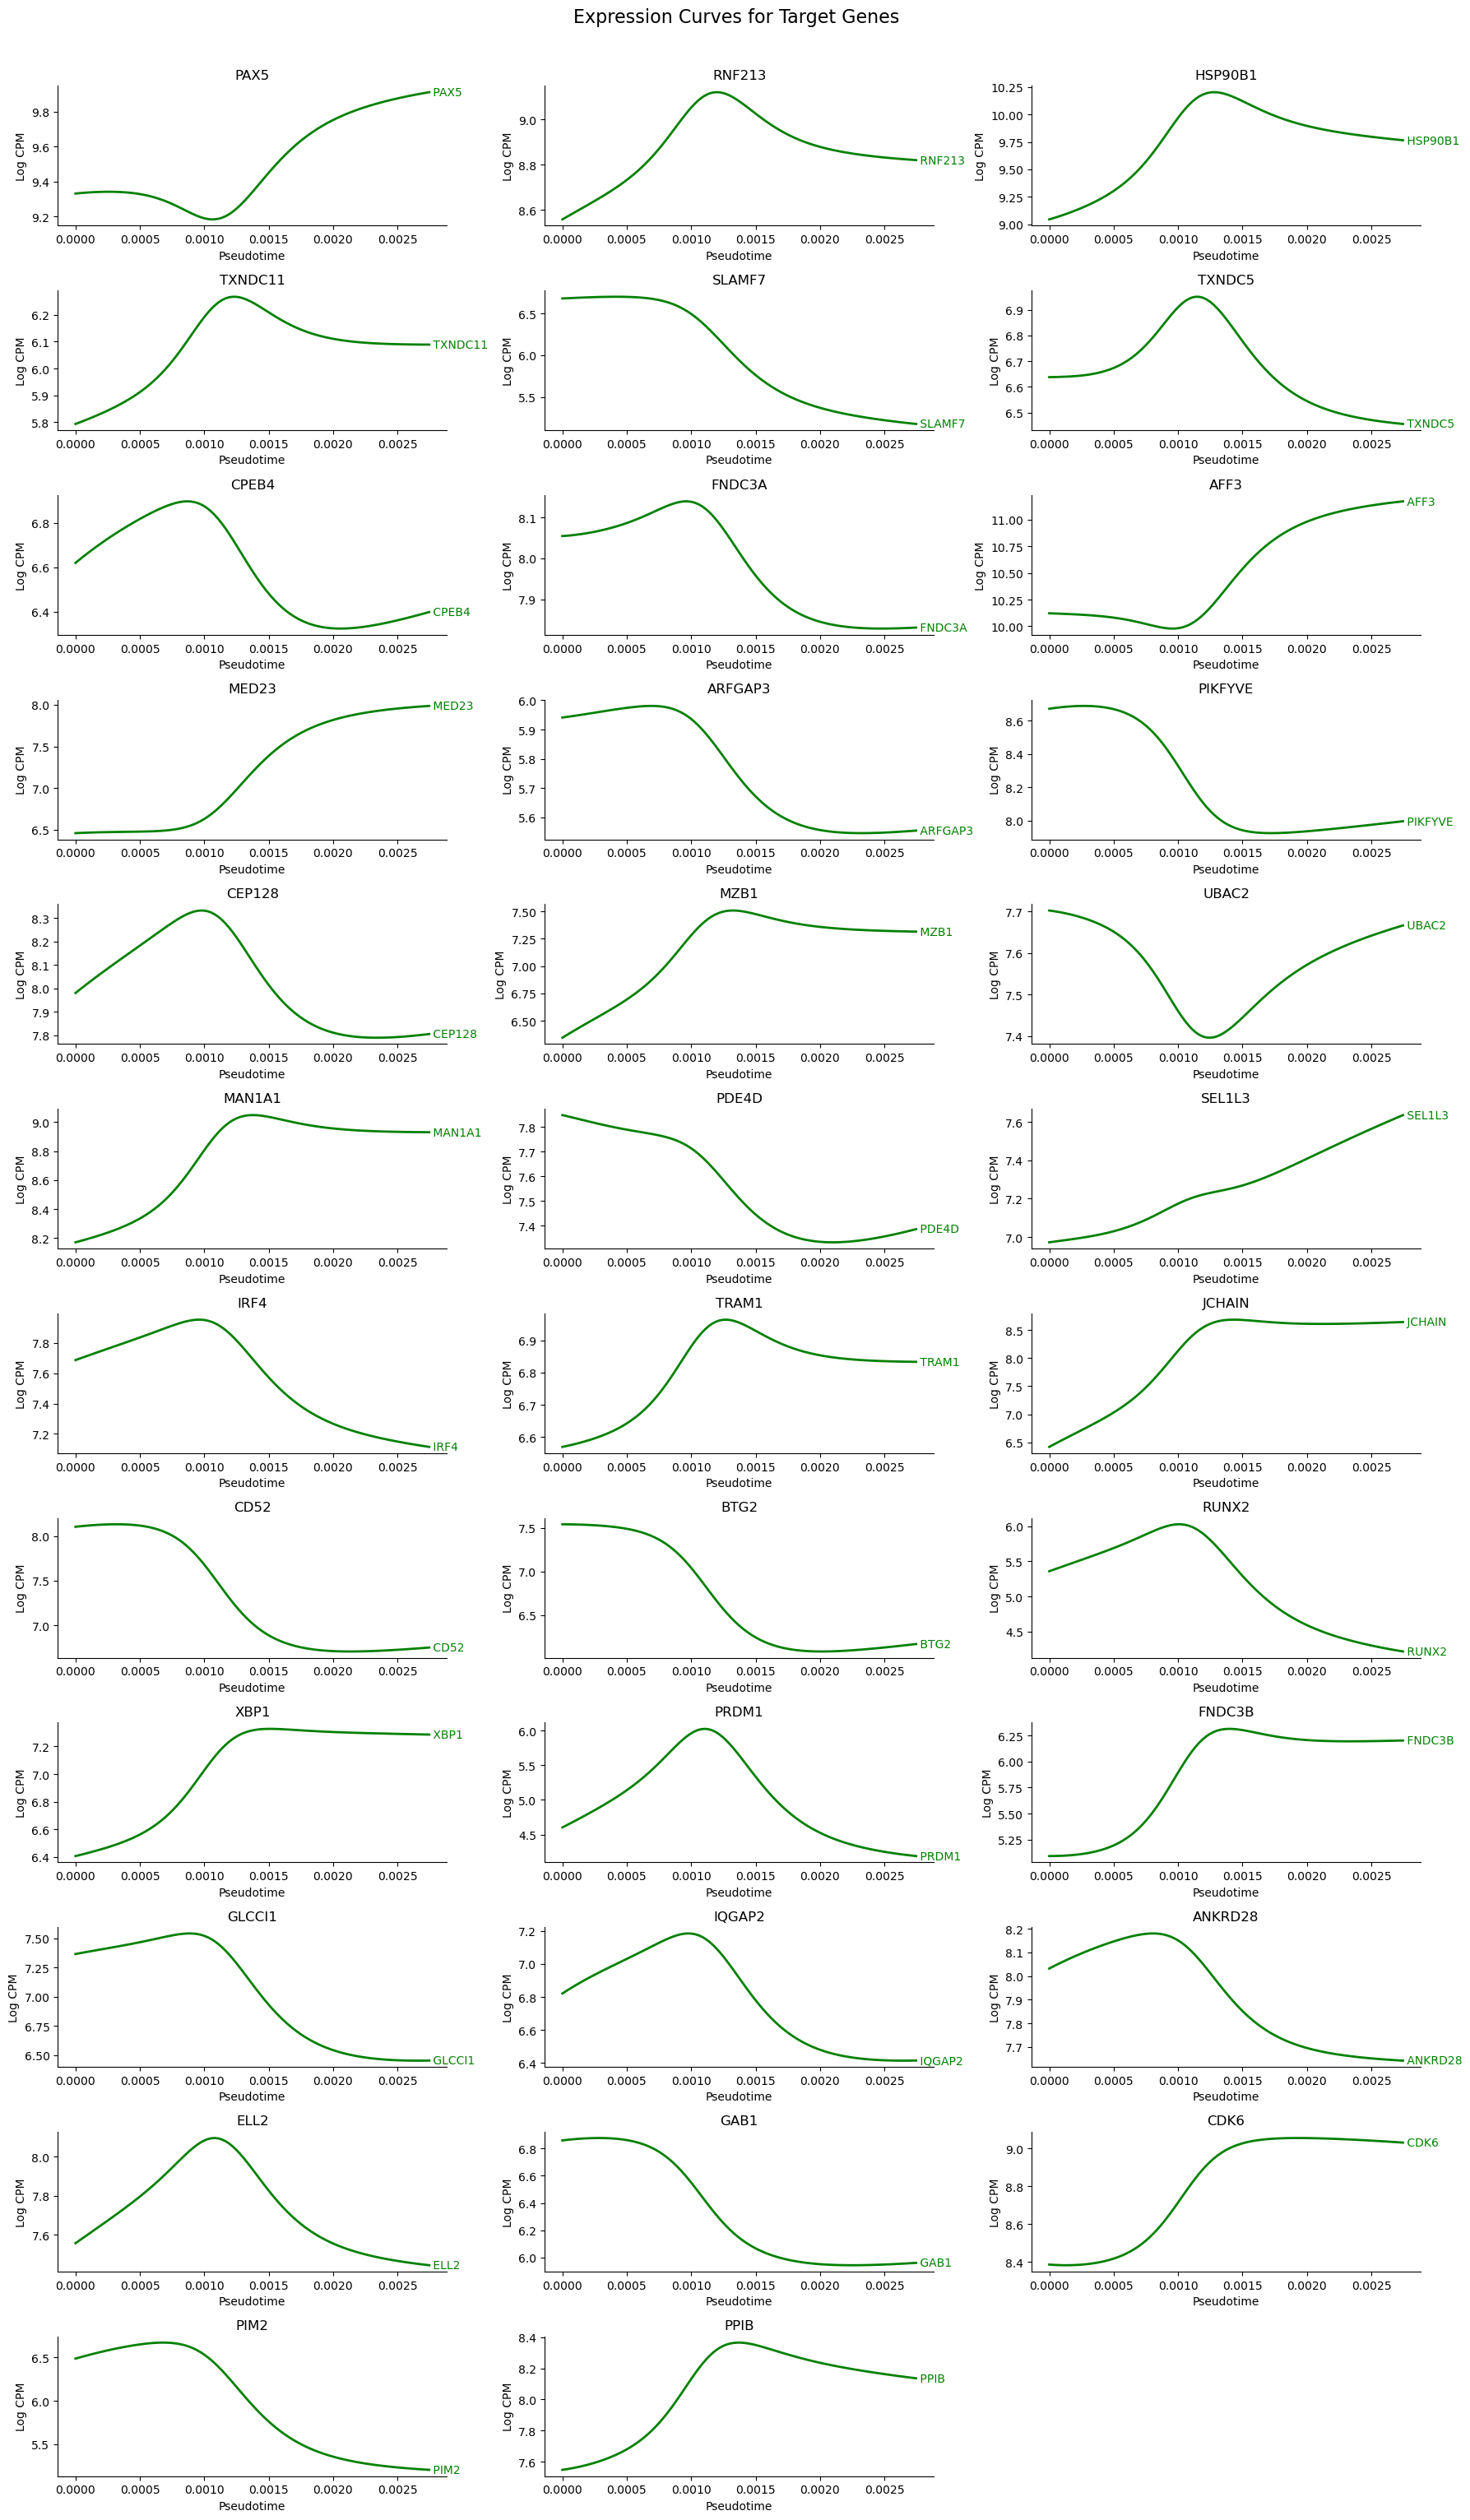

In [20]:
fig = plot_expression_for_multiple_genes(targets_in_lf, lcpm_dcurve, dtime, figsize=(18, 30))
plt.show()

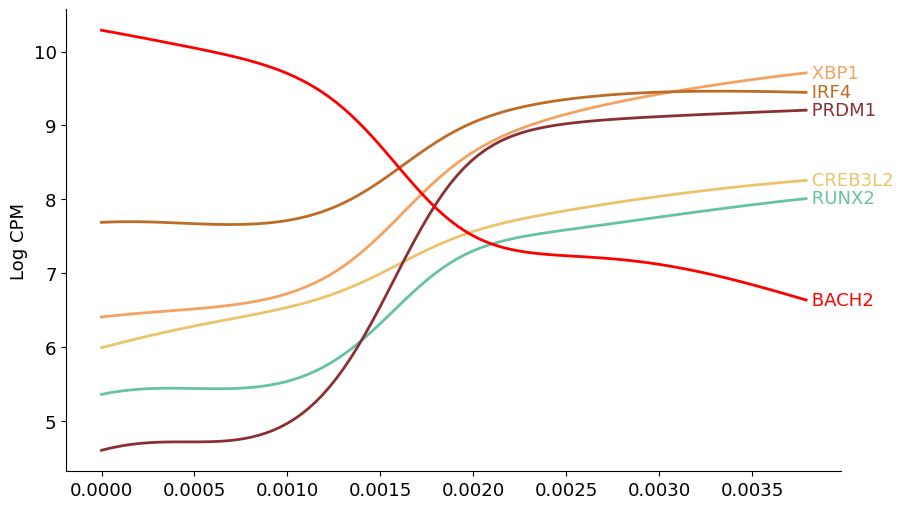

In [116]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['CREB3L2', 'RUNX2', 'XBP1', 'PRDM1', 'IRF4', 'BACH2']
colors = ['#e9c46a', '#66c2a5', '#f4a261', '#8a3033', '#bc6c25', '#ff0000']  # Mustard, light teal, peach, dark red, brown, bright red
# genes_of_interest = ['PAX5', 'RUNX2', 'XBP1', 'PRDM1', 'IRF4', 'AFF3']
# colors = ['#2e8b57', '#8b2500', '#32cd32', '#ff6347', '#b22222', '#00ced1']

for gene, color in zip(genes_of_interest, colors):
    if gene in lcpm_dcurve.index:
        line = plt.plot(dtime, lcpm_dcurve.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], lcpm_dcurve.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.ylabel('Log CPM')
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/TF_TF_expression_PB.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()